In [59]:
from pathlib import Path
import re

import scope
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", font_scale=1, palette="Paired")
plt.rcParams['figure.dpi'] = 300

In [62]:
def _read_float_file(path: Path, cutoff=200, min_length=None):
    reader = scope.Reader(path)
    steps, episode_scores = reader['episode/score']
    if min_length is not None:
        actual_steps = [steps[i] - (steps[i-1] if i > 0 else 0) for i in range(len(steps))]
        episode_scores = [score for i, score in enumerate(episode_scores) if actual_steps[i] >= min_length]
    
    if len(episode_scores) < cutoff:
        print(f"Warning: {path} has only {len(episode_scores)} episodes, less than the cutoff of {cutoff}.")
    return np.asarray(episode_scores)[:cutoff]

def plot_maniskill(files_labels=[], output=None):
    plt.figure(figsize=(10, 6))

    bars = []
    labels = []
    hue = []
    for path, label in files_labels:
        bars.append(_read_float_file(Path(path)).mean())
        *name, dist = label.split(" ")
        labels.append(" ".join(name))
        hue.append(dist)

    g = sns.catplot(
        kind="bar", x=labels, y=bars, hue=hue,
        errorbar="sd", palette="Set2", alpha=.8, height=6, aspect=2.5
    )
    g.despine(left=True)

    plt.xlabel("Environment Setting")
    plt.ylabel("Average Reward")
    plt.title(f"Average reward over 200 episodes")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")
    print(list(zip(labels, bars, hue)))

def plot_carla(files_labels=[], output=None):
    plt.figure(figsize=(20, 6))

    bars = []
    labels = []
    hue = []
    for path, label in files_labels:
        bars.append(_read_float_file(Path(path), cutoff=50, min_length=21).mean())
        *name, dist = label.split(" ")
        labels.append(" ".join(name))
        hue.append(dist)

    g = sns.catplot(
        kind="bar", x=labels, y=bars, hue=hue,
        errorbar="se", palette="Set2", alpha=.8, height=6, aspect=2.5
    )
    g.despine(left=True)

    plt.xlabel("Environment Setting")
    plt.ylabel("Average Reward")
    plt.title(f"Average reward over 50 episodes and 3 seeds")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")
    print(list(zip(labels, bars, hue)))

[('Baseline', 10.91115521316242, 'ID'), ('Baseline', 10.548903430586797, 'OOD'), ('Baseline', 0.08995095134399662, 'texture'), ('DINO finetune', 10.886660591497861, 'ID'), ('DINO finetune', 10.163853350208697, 'OOD'), ('DINO finetune', 0.07461831144373036, 'texture'), ('DINO Partial', 9.802362432804657, 'ID'), ('DINO Partial', 9.4049647959051, 'OOD'), ('DINO Partial', 0.10438953358469473, 'texture'), ('DINO frozen', 9.37123670268617, 'ID'), ('DINO frozen', 8.77676312987227, 'OOD'), ('DINO frozen', 1.5524350217776373, 'texture')]


<Figure size 3000x1800 with 0 Axes>

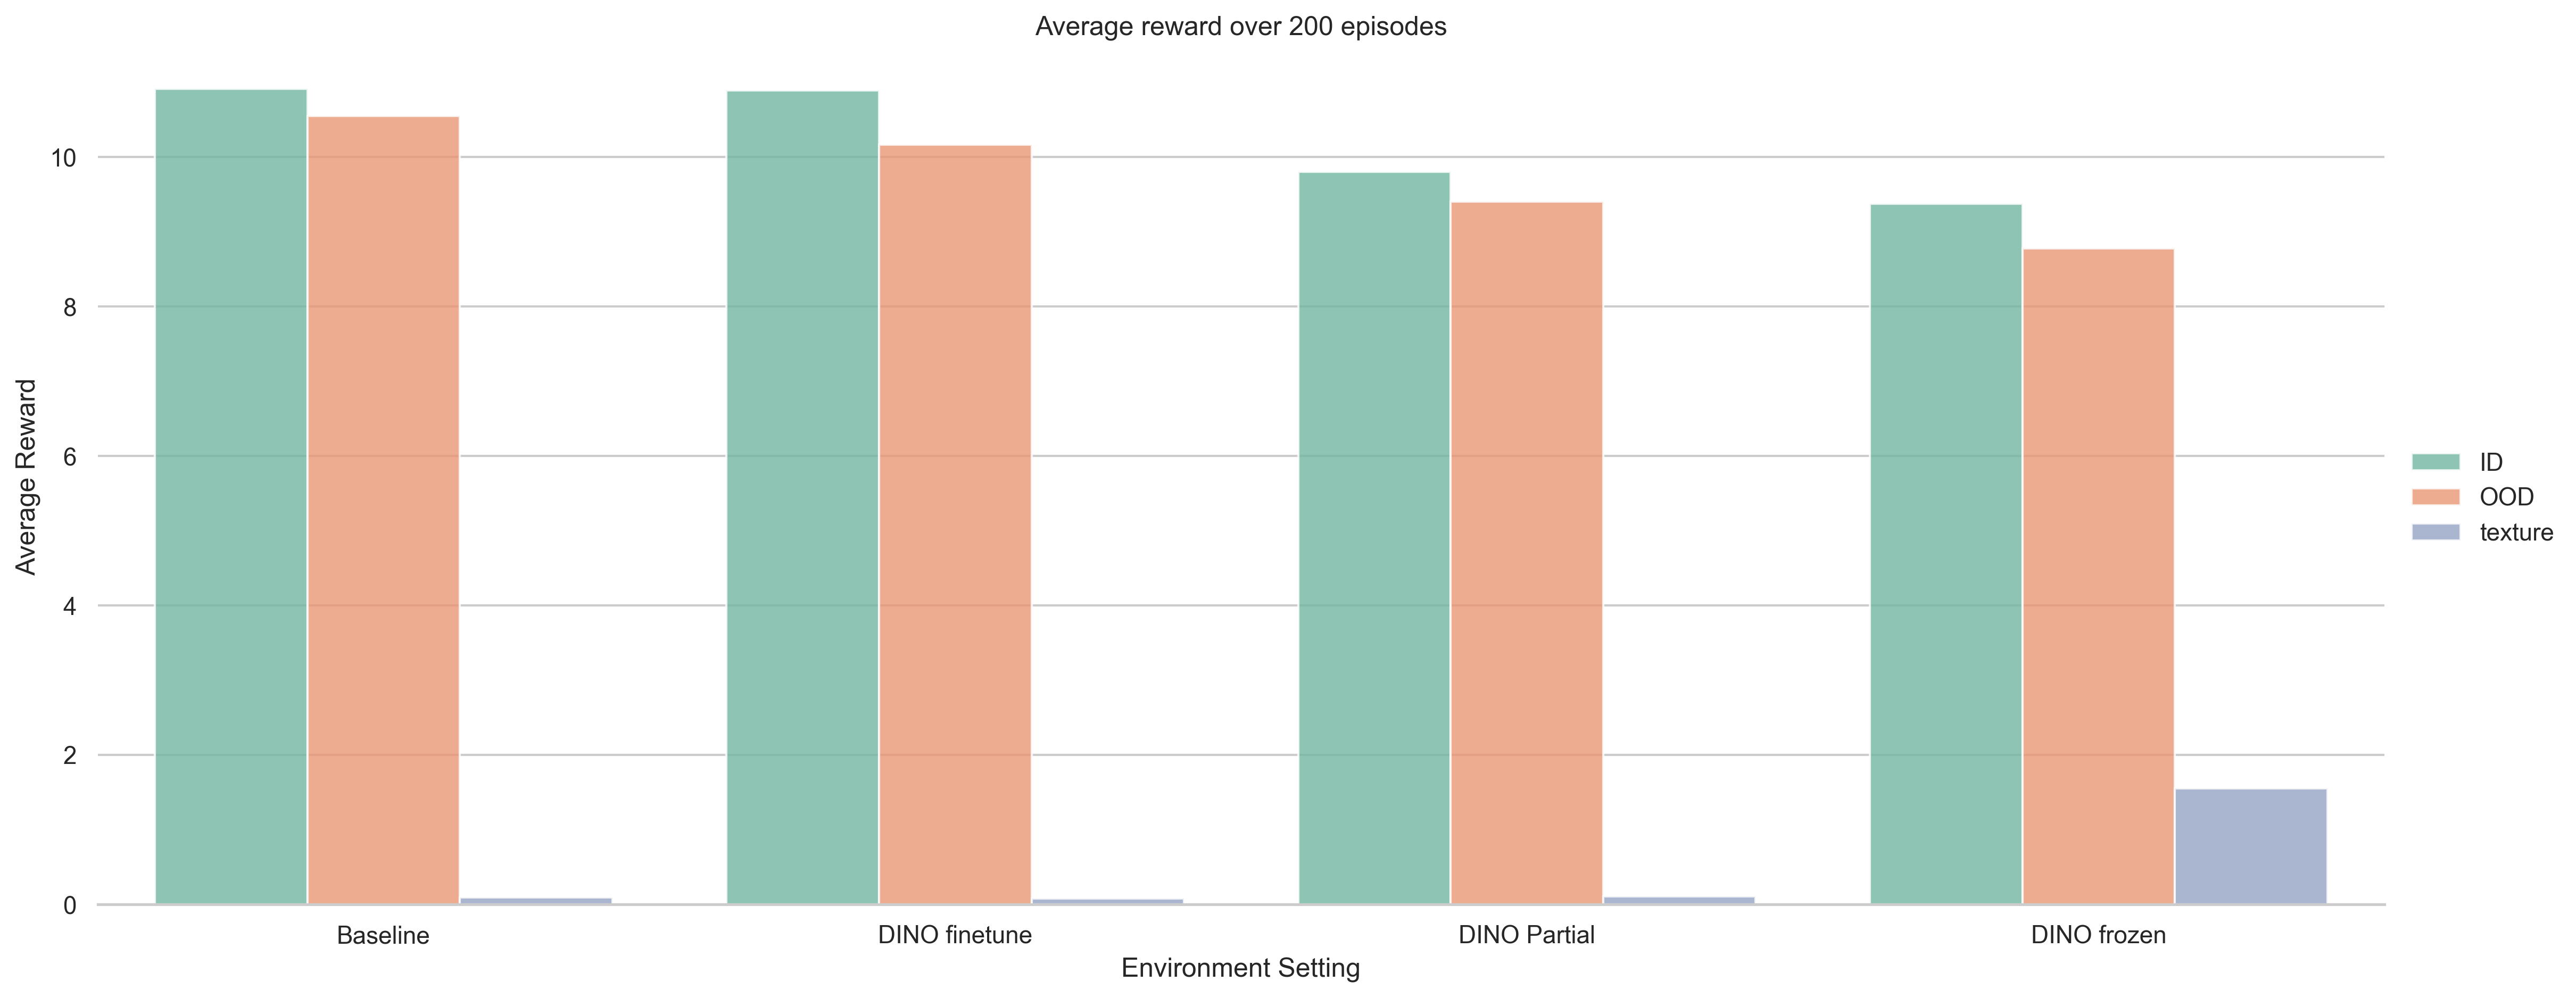

In [ ]:
plot_maniskill(
    files_labels=[
        ("logdir/PICK_YCB/baseline_pick_ycb_eval_ID/", "Baseline ID"),
        ("logdir/PICK_YCB/baseline_pick_ycb_eval_OOD/", "Baseline OOD"),
        ("logdir/baseline_pick_ycb_eval_OD_texture/", "Baseline texture"),

        ("logdir/PICK_YCB/DINOFT_pick_ycb_eval_ID/", "DINO finetune ID"),
        ("logdir/PICK_YCB/DINOFT_pick_ycb_eval_OOD/", "DINO finetune OOD"),
        ("logdir/DINOFT_pick_ycb_eval_OD_texture/", "DINO finetune texture"),

        ("logdir/PICK_YCB/DINOPartial_pick_ycb_eval_ID/", "DINO Partial ID"),
        ("logdir/PICK_YCB/DINOPartial_pick_ycb_eval_OOD/", "DINO Partial OOD"),
        ("logdir/DINOPartial_pick_ycb_eval_OD_texture/", "DINO Partial texture"),

        ("logdir/PICK_YCB/DINOFreeze_pick_ycb_eval_ID/", "DINO frozen ID"),
        ("logdir/PICK_YCB/DINOFreeze_pick_ycb_eval_OOD/", "DINO frozen OOD"),
        ("logdir/DINOFreeze_pick_ycb_eval_OD_texture/", "DINO frozen texture"),
    ]
)

[('Baseline', 62.02624958534027, 'easy'), ('Baseline', 41.71867405593395, 'easy'), ('Baseline', 70.5092355363071, 'easy'), ('Baseline', 38.336922818725, 'easy'), ('Baseline', 21.271455326806755, 'easy'), ('Baseline', 70.43066598370672, 'easy'), ('Baseline', 18.422632095249572, 'hard'), ('Baseline', 12.629755065776408, 'hard'), ('Baseline', 16.018499172329904, 'hard'), ('Baseline', 18.476093610338868, 'hard'), ('Baseline', 12.25647440481931, 'hard'), ('Baseline', 16.242754259221257, 'hard'), ('DINO finetune', 435.0366029392742, 'easy'), ('DINO finetune', 276.68885518491265, 'easy'), ('DINO finetune', 297.5157962680608, 'easy'), ('DINO finetune', 174.02530940031866, 'easy'), ('DINO finetune', 322.4706159534864, 'easy'), ('DINO finetune', 283.25912559203806, 'easy'), ('DINO finetune', 40.59258689611335, 'hard'), ('DINO finetune', 81.11631562289665, 'hard'), ('DINO finetune', 8.771258620651787, 'hard'), ('DINO finetune', 19.95919989963644, 'hard'), ('DINO finetune', 50.343977562341315, 'ha

<Figure size 6000x1800 with 0 Axes>

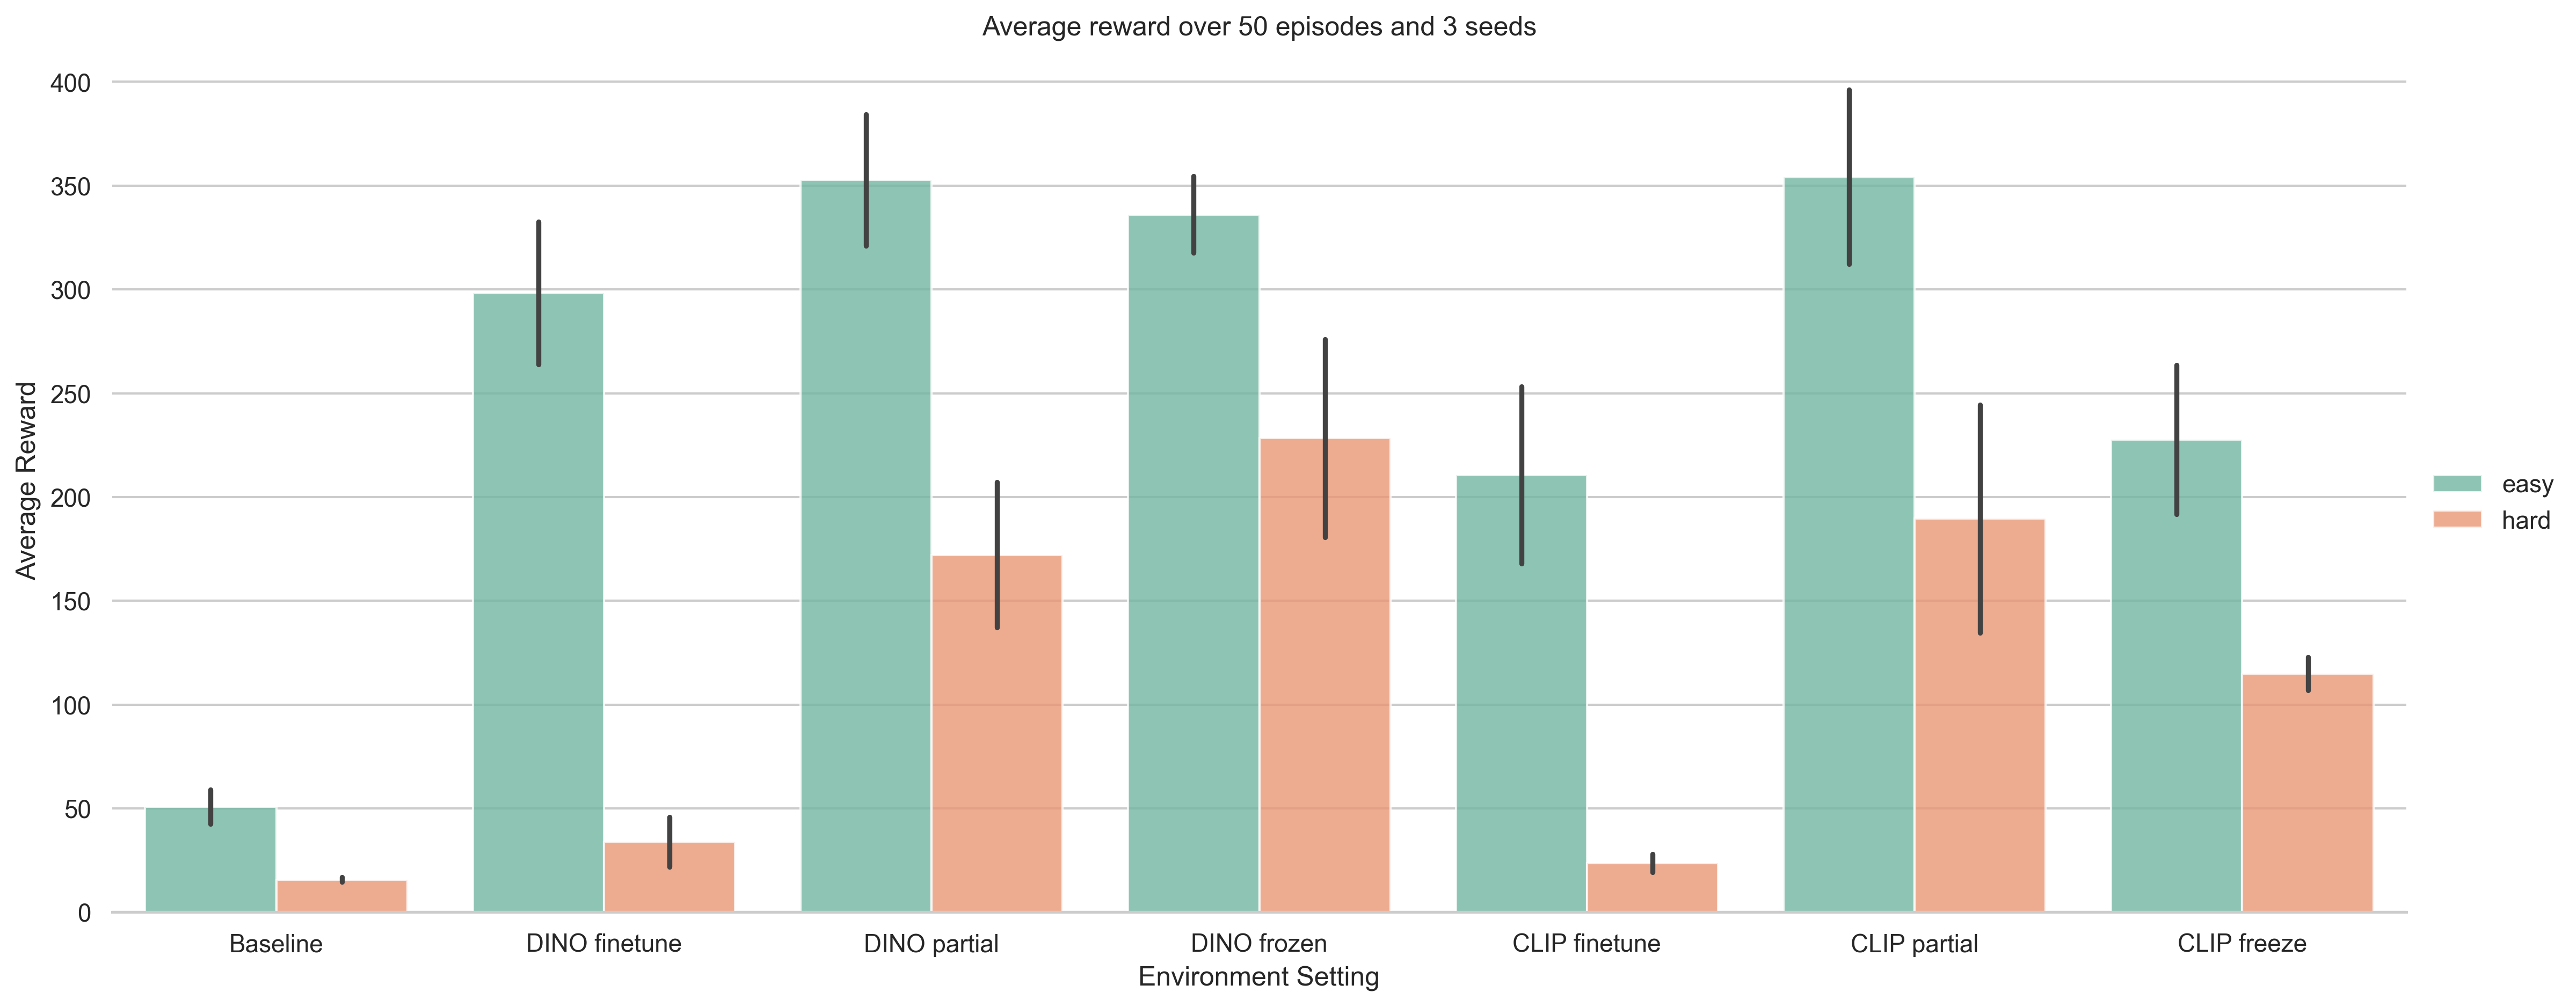

In [64]:
plot_carla(
    files_labels=[
        # ("logdir/baseline_carla_eval_ID/", "Baseline ID"),
        # ("logdir/baseline_carla_eval_ID_1", "Baseline ID"),
        # ("logdir/baseline_carla_eval_ID_2", "Baseline ID"),
        # ("logdir/DINOFT_carla_eval_ID", "DINO finetune ID"),
        # ("logdir/DINOPartial_carla_eval_ID", "DINO partial ID"),
        # ("logdir/DINOFreeze_carla_eval_ID", "DINO frozen ID"),

        # ------------- soft high light -------------
        # ("logdir/baseline_carla_eval_soft_high_light", "Baseline softhighlight"),
        # ("logdir/baseline_carla_eval_soft_high_light_1", "Baseline softhighlight"),
        # ("logdir/baseline_carla_eval_soft_high_light_2", "Baseline softhighlight"),

        # ("logdir/DINOFT_carla_eval_soft_high_light", "DINO finetune softhighlight"),
        # ("logdir/DINOFT_carla_eval_soft_high_light_1", "DINO finetune softhighlight"),
        # ("logdir/DINOFT_carla_eval_soft_high_light_2", "DINO finetune softhighlight"),

        # ("logdir/DINOPartial_carla_eval_soft_high_light", "DINO partial softhighlight"),
        # ("logdir/DINOPartial_carla_eval_soft_high_light_1", "DINO partial softhighlight"),
        # ("logdir/DINOPartial_carla_eval_soft_high_light_2", "DINO partial softhighlight"),

        # ("logdir/DINOFreeze_carla_eval_soft_high_light", "DINO frozen softhighlight"),
        # ("logdir/DINOFreeze_carla_eval_soft_high_light_1", "DINO frozen softhighlight"),
        # ("logdir/DINOFreeze_carla_eval_soft_high_light_2", "DINO frozen softhighlight"),

        # ("logdir/CLIPFT_carla_eval_soft_high_light", "CLIP finetune softhighlight"),
        # ("logdir/CLIPFT_carla_eval_soft_high_light_1", "CLIP finetune softhighlight"),
        # ("logdir/CLIPFT_carla_eval_soft_high_light_2", "CLIP finetune softhighlight"),

        # ("logdir/CLIPPartial_carla_eval_soft_high_light", "CLIP partial softhighlight"),

        # ("logdir/CLIPFreeze_carla_eval_soft_high_light", "CLIP freeze softhighlight"),
        # ("logdir/CLIPFreeze_carla_eval_soft_high_light_1", "CLIP freeze softhighlight"),
        # ("logdir/CLIPFreeze_carla_eval_soft_high_light_2", "CLIP freeze softhighlight"),

        # # ------------- soft low light -------------
        # ("logdir/baseline_carla_eval_soft_noisy_low_light", "Baseline softnoisylowlight"),
        # ("logdir/baseline_carla_eval_soft_noisy_low_light_1", "Baseline softnoisylowlight"),
        # ("logdir/baseline_carla_eval_soft_noisy_low_light_2", "Baseline softnoisylowlight"),

        # ("logdir/DINOFT_carla_eval_soft_noisy_low_light", "DINO finetune softnoisylowlight"),
        # ("logdir/DINOFT_carla_eval_soft_noisy_low_light_1", "DINO finetune softnoisylowlight"),
        # ("logdir/DINOFT_carla_eval_soft_noisy_low_light_2", "DINO finetune softnoisylowlight"),

        # ("logdir/DINOPartial_carla_eval_soft_noisy_low_light", "DINO partial softnoisylowlight"),
        # ("logdir/DINOPartial_carla_eval_soft_noisy_low_light_1", "DINO partial softnoisylowlight"),
        # ("logdir/DINOPartial_carla_eval_soft_noisy_low_light_2", "DINO partial softnoisylowlight"),

        # ("logdir/DINOFreeze_carla_eval_soft_noisy_low_light", "DINO frozen softnoisylowlight"),
        # ("logdir/DINOFreeze_carla_eval_soft_noisy_low_light_1", "DINO frozen softnoisylowlight"),
        # ("logdir/DINOFreeze_carla_eval_soft_noisy_low_light_2", "DINO frozen softnoisylowlight"),
        
        # ("logdir/CLIPFT_carla_eval_soft_noisy_low_light", "CLIP finetune softnoisylowlight"),
        # ("logdir/CLIPFT_carla_eval_soft_noisy_low_light_1", "CLIP finetune softnoisylowlight"),
        # ("logdir/CLIPFT_carla_eval_soft_noisy_low_light_2", "CLIP finetune softnoisylowlight"),

        # ("logdir/CLIPPartial_carla_eval_soft_noisy_low_light", "CLIP partial softnoisylowlight"),

        # ("logdir/CLIPFreeze_carla_eval_soft_noisy_low_light", "CLIP freeze softnoisylowlight"),
        # ("logdir/CLIPFreeze_carla_eval_soft_noisy_low_light_1", "CLIP freeze softnoisylowlight"),
        # ("logdir/CLIPFreeze_carla_eval_soft_noisy_low_light_2", "CLIP freeze softnoisylowlight"),

        # # ------------- hard low light -------------
        # ("logdir/baseline_carla_eval_hard_low_light", "Baseline hardlowlight"),
        # ("logdir/baseline_carla_eval_hard_low_light_1", "Baseline hardlowlight"),
        # ("logdir/baseline_carla_eval_hard_low_light_2", "Baseline hardlowlight"),

        # ("logdir/DINOFT_carla_eval_hard_low_light", "DINO finetune hardlowlight"),
        # ("logdir/DINOFT_carla_eval_hard_low_light_1", "DINO finetune hardlowlight"),
        # ("logdir/DINOFT_carla_eval_hard_low_light_2", "DINO finetune hardlowlight"),
        
        # ("logdir/DINOPartial_carla_eval_hard_low_light", "DINO partial hardlowlight"),
        # ("logdir/DINOPartial_carla_eval_hard_low_light_1", "DINO partial hardlowlight"),
        # ("logdir/DINOPartial_carla_eval_hard_low_light_2", "DINO partial hardlowlight"),

        # ("logdir/DINOFreeze_carla_eval_hard_low_light", "DINO frozen hardlowlight"),
        # ("logdir/DINOFreeze_carla_eval_hard_low_light_1", "DINO frozen hardlowlight"),
        # ("logdir/DINOFreeze_carla_eval_hard_low_light_2", "DINO frozen hardlowlight"),

        # ("logdir/CLIPFT_carla_eval_hard_low_light", "CLIP finetune hardlowlight"),
        # ("logdir/CLIPFT_carla_eval_hard_low_light_1", "CLIP finetune hardlowlight"),
        # ("logdir/CLIPFT_carla_eval_hard_low_light_2", "CLIP finetune hardlowlight"),

        # ("logdir/CLIPPartial_carla_eval_hard_low_light", "CLIP partial hardlowlight"),

        # ("logdir/CLIPFreeze_carla_eval_hard_low_light", "CLIP freeze hardlowlight"),
        # ("logdir/CLIPFreeze_carla_eval_hard_low_light_1", "CLIP freeze hardlowlight"),
        # ("logdir/CLIPFreeze_carla_eval_hard_low_light_2", "CLIP freeze hardlowlight"),


        # # ------------- hard noisy low light -------------
        # ("logdir/baseline_carla_eval_hard_noisy_low_light", "Baseline hardnoisylowlight"),
        # ("logdir/baseline_carla_eval_hard_noisy_low_light_1", "Baseline hardnoisylowlight"),
        # ("logdir/baseline_carla_eval_hard_noisy_low_light_2", "Baseline hardnoisylowlight"),

        # ("logdir/DINOFT_carla_eval_hard_noisy_low_light", "DINO finetune hardnoisylowlight"),
        # ("logdir/DINOFT_carla_eval_hard_noisy_low_light_1", "DINO finetune hardnoisylowlight"),
        # ("logdir/DINOFT_carla_eval_hard_noisy_low_light_2", "DINO finetune hardnoisylowlight"),

        # ("logdir/DINOPartial_carla_eval_hard_noisy_low_light", "DINO partial hardnoisylowlight"),
        # ("logdir/DINOPartial_carla_eval_hard_noisy_low_light_1", "DINO partial hardnoisylowlight"),
        # ("logdir/DINOPartial_carla_eval_hard_noisy_low_light_2", "DINO partial hardnoisylowlight"),

        # ("logdir/DINOFreeze_carla_eval_hard_noisy_low_light", "DINO frozen hardnoisylowlight"),
        # ("logdir/DINOFreeze_carla_eval_hard_noisy_low_light_1", "DINO frozen hardnoisylowlight"),
        # ("logdir/DINOFreeze_carla_eval_hard_noisy_low_light_2", "DINO frozen hardnoisylowlight"),

        # ("logdir/CLIPFT_carla_eval_hard_noisy_low_light", "CLIP finetune hardnoisylowlight"),
        # ("logdir/CLIPFT_carla_eval_hard_noisy_low_light_1", "CLIP finetune hardnoisylowlight"),
        # ("logdir/CLIPFT_carla_eval_hard_noisy_low_light_2", "CLIP finetune hardnoisylowlight"),

        # ("logdir/CLIPPartial_carla_eval_hard_noisy_low_light", "CLIP partial hardnoisylowlight"),

        # ("logdir/CLIPFreeze_carla_eval_hard_noisy_low_light", "CLIP freeze hardnoisylowlight"),
        # ("logdir/CLIPFreeze_carla_eval_hard_noisy_low_light_1", "CLIP freeze hardnoisylowlight"),
        # ("logdir/CLIPFreeze_carla_eval_hard_noisy_low_light_2", "CLIP freeze hardnoisylowlight"),

        # ------------- gathered results -------------
        ("logdir/baseline_carla_eval_soft_high_light", "Baseline easy"),
        ("logdir/baseline_carla_eval_soft_high_light_1", "Baseline easy"),
        ("logdir/baseline_carla_eval_soft_high_light_2", "Baseline easy"),
        ("logdir/baseline_carla_eval_soft_noisy_low_light", "Baseline easy"),
        ("logdir/baseline_carla_eval_soft_noisy_low_light_1", "Baseline easy"),
        ("logdir/baseline_carla_eval_soft_noisy_low_light_2", "Baseline easy"),

        ("logdir/baseline_carla_eval_hard_low_light", "Baseline hard"),
        ("logdir/baseline_carla_eval_hard_low_light_1", "Baseline hard"),
        ("logdir/baseline_carla_eval_hard_low_light_2", "Baseline hard"),
        ("logdir/baseline_carla_eval_hard_noisy_low_light", "Baseline hard"),
        ("logdir/baseline_carla_eval_hard_noisy_low_light_1", "Baseline hard"),
        ("logdir/baseline_carla_eval_hard_noisy_low_light_2", "Baseline hard"),

        ("logdir/DINOFT_carla_eval_soft_high_light", "DINO finetune easy"),
        ("logdir/DINOFT_carla_eval_soft_high_light_1", "DINO finetune easy"),
        ("logdir/DINOFT_carla_eval_soft_high_light_2", "DINO finetune easy"),
        ("logdir/DINOFT_carla_eval_soft_noisy_low_light", "DINO finetune easy"),
        ("logdir/DINOFT_carla_eval_soft_noisy_low_light_1", "DINO finetune easy"),
        ("logdir/DINOFT_carla_eval_soft_noisy_low_light_2", "DINO finetune easy"),

        ("logdir/DINOFT_carla_eval_hard_low_light", "DINO finetune hard"),
        ("logdir/DINOFT_carla_eval_hard_low_light_1", "DINO finetune hard"),
        ("logdir/DINOFT_carla_eval_hard_low_light_2", "DINO finetune hard"),
        ("logdir/DINOFT_carla_eval_hard_noisy_low_light", "DINO finetune hard"),
        ("logdir/DINOFT_carla_eval_hard_noisy_low_light_1", "DINO finetune hard"),
        ("logdir/DINOFT_carla_eval_hard_noisy_low_light_2", "DINO finetune hard"),
        
        ("logdir/DINOPartial_carla_eval_soft_high_light", "DINO partial easy"),
        ("logdir/DINOPartial_carla_eval_soft_high_light_1", "DINO partial easy"),
        ("logdir/DINOPartial_carla_eval_soft_high_light_2", "DINO partial easy"),
        ("logdir/DINOPartial_carla_eval_soft_noisy_low_light", "DINO partial easy"),
        ("logdir/DINOPartial_carla_eval_soft_noisy_low_light_1", "DINO partial easy"),
        ("logdir/DINOPartial_carla_eval_soft_noisy_low_light_2", "DINO partial easy"),

        ("logdir/DINOPartial_carla_eval_hard_low_light", "DINO partial hard"),
        ("logdir/DINOPartial_carla_eval_hard_low_light_1", "DINO partial hard"),
        ("logdir/DINOPartial_carla_eval_hard_low_light_2", "DINO partial hard"),
        ("logdir/DINOPartial_carla_eval_hard_noisy_low_light", "DINO partial hard"),
        ("logdir/DINOPartial_carla_eval_hard_noisy_low_light_1", "DINO partial hard"),
        ("logdir/DINOPartial_carla_eval_hard_noisy_low_light_2", "DINO partial hard"),

        ("logdir/DINOFreeze_carla_eval_soft_noisy_low_light", "DINO frozen easy"),
        ("logdir/DINOFreeze_carla_eval_soft_noisy_low_light_1", "DINO frozen easy"),
        ("logdir/DINOFreeze_carla_eval_soft_noisy_low_light_2", "DINO frozen easy"),
        ("logdir/DINOFreeze_carla_eval_soft_high_light", "DINO frozen easy"),
        ("logdir/DINOFreeze_carla_eval_soft_high_light_1", "DINO frozen easy"),
        ("logdir/DINOFreeze_carla_eval_soft_high_light_2", "DINO frozen easy"),

        ("logdir/DINOFreeze_carla_eval_hard_noisy_low_light", "DINO frozen hard"),
        ("logdir/DINOFreeze_carla_eval_hard_noisy_low_light_1", "DINO frozen hard"),
        ("logdir/DINOFreeze_carla_eval_hard_noisy_low_light_2", "DINO frozen hard"),
        ("logdir/DINOFreeze_carla_eval_hard_low_light", "DINO frozen hard"),
        ("logdir/DINOFreeze_carla_eval_hard_low_light_1", "DINO frozen hard"),
        ("logdir/DINOFreeze_carla_eval_hard_low_light_2", "DINO frozen hard"),

        ("logdir/CLIPFT_carla_eval_soft_noisy_low_light", "CLIP finetune easy"),
        ("logdir/CLIPFT_carla_eval_soft_noisy_low_light_1", "CLIP finetune easy"),
        ("logdir/CLIPFT_carla_eval_soft_noisy_low_light_2", "CLIP finetune easy"),
        ("logdir/CLIPFT_carla_eval_soft_high_light", "CLIP finetune easy"),
        ("logdir/CLIPFT_carla_eval_soft_high_light_1", "CLIP finetune easy"),
        ("logdir/CLIPFT_carla_eval_soft_high_light_2", "CLIP finetune easy"),

        ("logdir/CLIPFT_carla_eval_hard_noisy_low_light", "CLIP finetune hard"),
        ("logdir/CLIPFT_carla_eval_hard_noisy_low_light_1", "CLIP finetune hard"),
        ("logdir/CLIPFT_carla_eval_hard_noisy_low_light_2", "CLIP finetune hard"),
        ("logdir/CLIPFT_carla_eval_hard_low_light", "CLIP finetune hard"),
        ("logdir/CLIPFT_carla_eval_hard_low_light_1", "CLIP finetune hard"),
        ("logdir/CLIPFT_carla_eval_hard_low_light_2", "CLIP finetune hard"),

        ("logdir/CLIPPartial_carla_eval_soft_noisy_low_light", "CLIP partial easy"),
        ("logdir/CLIPPartial_carla_eval_soft_noisy_low_light_1", "CLIP partial easy"),
        ("logdir/CLIPPartial_carla_eval_soft_noisy_low_light_2", "CLIP partial easy"),
        ("logdir/CLIPPartial_carla_eval_soft_high_light", "CLIP partial easy"),
        ("logdir/CLIPPartial_carla_eval_soft_high_light_1", "CLIP partial easy"),
        ("logdir/CLIPPartial_carla_eval_soft_high_light_2", "CLIP partial easy"),

        ("logdir/CLIPPartial_carla_eval_hard_noisy_low_light", "CLIP partial hard"),
        ("logdir/CLIPPartial_carla_eval_hard_noisy_low_light_1", "CLIP partial hard"),
        ("logdir/CLIPPartial_carla_eval_hard_noisy_low_light_2", "CLIP partial hard"),
        ("logdir/CLIPPartial_carla_eval_hard_low_light", "CLIP partial hard"),
        ("logdir/CLIPPartial_carla_eval_hard_low_light_1", "CLIP partial hard"),
        ("logdir/CLIPPartial_carla_eval_hard_low_light_2", "CLIP partial hard"),

        ("logdir/CLIPFreeze_carla_eval_soft_noisy_low_light", "CLIP freeze easy"),
        ("logdir/CLIPFreeze_carla_eval_soft_noisy_low_light_1", "CLIP freeze easy"),
        ("logdir/CLIPFreeze_carla_eval_soft_noisy_low_light_2", "CLIP freeze easy"),
        ("logdir/CLIPFreeze_carla_eval_soft_high_light", "CLIP freeze easy"),
        ("logdir/CLIPFreeze_carla_eval_soft_high_light_1", "CLIP freeze easy"),
        ("logdir/CLIPFreeze_carla_eval_soft_high_light_2", "CLIP freeze easy"),

        ("logdir/CLIPFreeze_carla_eval_hard_noisy_low_light", "CLIP freeze hard"),
        ("logdir/CLIPFreeze_carla_eval_hard_noisy_low_light_1", "CLIP freeze hard"),
        ("logdir/CLIPFreeze_carla_eval_hard_noisy_low_light_2", "CLIP freeze hard"),
        ("logdir/CLIPFreeze_carla_eval_hard_low_light", "CLIP freeze hard"),
        ("logdir/CLIPFreeze_carla_eval_hard_low_light_1", "CLIP freeze hard"),
        ("logdir/CLIPFreeze_carla_eval_hard_low_light_2", "CLIP freeze hard"),
    ]
)

## Catastrophic Forgetting
In this experiment we train a K-Nearest Neighbours model on the output representation from the DinoV2 models before and after end-to-end finetuning with DreamerV3. In this small diagnostic test we trained using a 80:20 split from 20k ImageNet images.

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_3562/1506220593.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=imagenet_knn_accuracy, x=imagenet_knn_labels, palette="Set2", width=0.5, alpha=0.8)


<Axes: title={'center': 'Catastrophic Forgetting: ImageNet KNN Accuracy'}, xlabel='Model Type', ylabel='Test Accuracy (%)'>

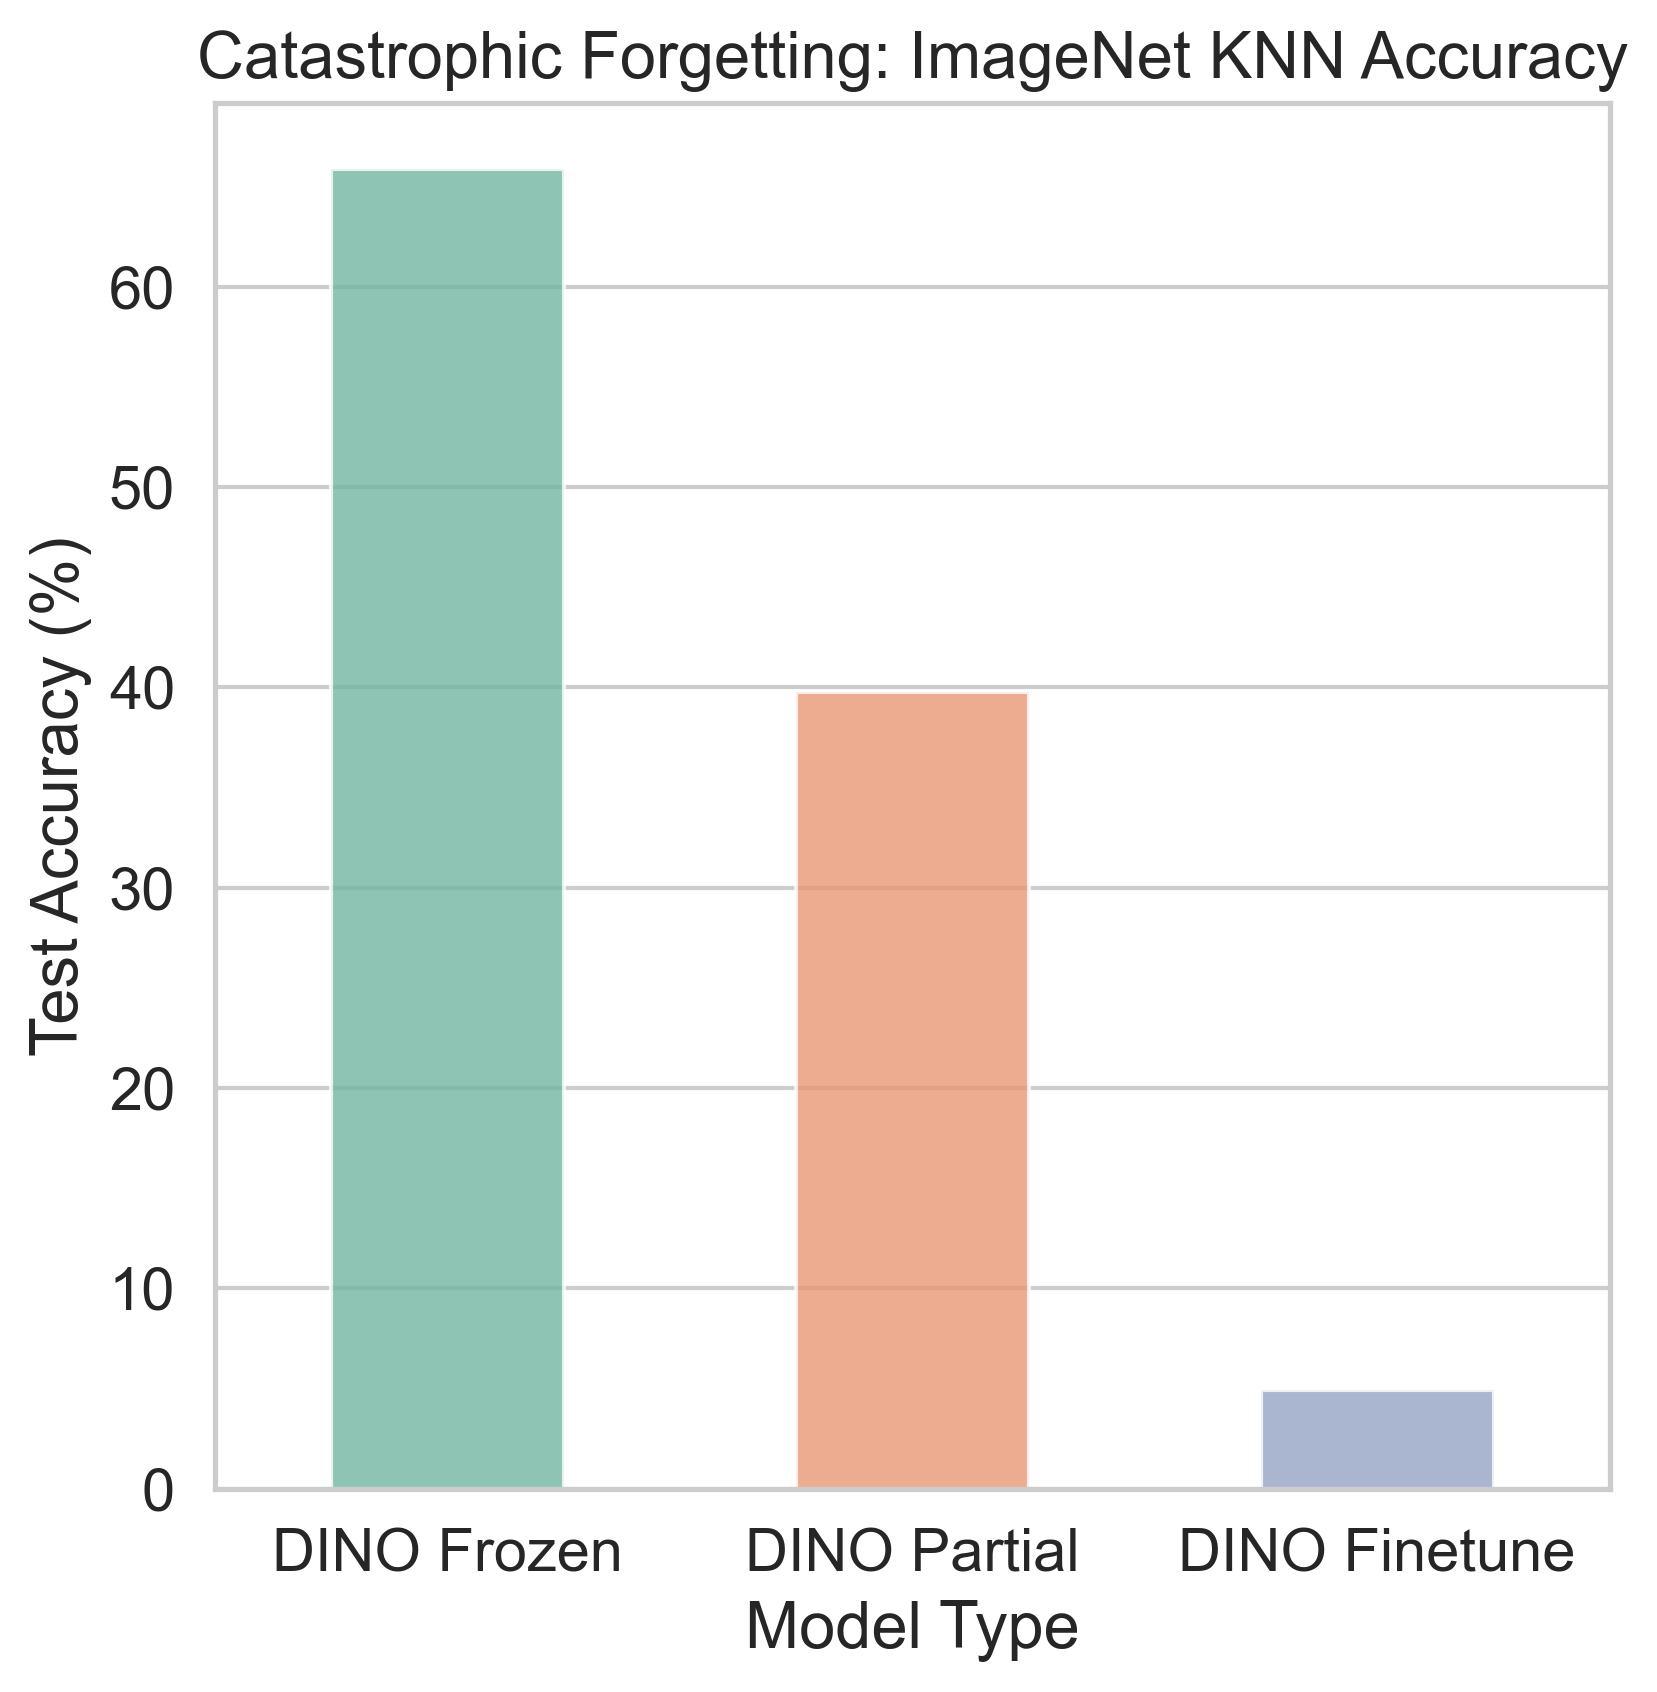

In [13]:
imagenet_knn_accuracy = [65.88, 39.77, 4.92]
imagenet_knn_labels = ["DINO Frozen", "DINO Partial", "DINO Finetune"]
plt.figure(figsize=(6, 6))
plt.xlabel("Model Type")
plt.ylabel("Test Accuracy (%)")
plt.title(f"Catastrophic Forgetting: ImageNet KNN Accuracy")
sns.barplot(y=imagenet_knn_accuracy, x=imagenet_knn_labels, palette="Set2", width=0.5, alpha=0.8)